<a href="https://colab.research.google.com/github/alecinvan/Colab_AI_tutorial/blob/main/Colab_openAI_embedding_pinecone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="blue" size="5">**Pinecone**是一个高性能、实时的向量数据库（**Vector Database**），专门用于存储、检索和分析高维向量数据。它被设计用来处理大规模的向量数据，如嵌入式表示、特征向量、嵌入向量等，以便支持多种应用，包括推荐系统、搜索引擎、相似性匹配、聚类分析等。<br>

首先安装pinecone *client端*

In [1]:
!pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 7.8 MB/s eta 0:00:00


In [21]:
!pip install -qU \
    openai==0.27.7 \
    pinecone_datasets=='0.5.0rc11' \
    tqdm

<font color="red" size="5">建立知识库 <br>

构建更可靠的LLM工具需要外部“知识库”，这是我们可以存储和使用以有效检索信息的地方。 我们可以将其视为我们LLM的外部长期记忆。
我们需要检索与我们的查询语义相关的信息，为此我们需要使用“密集向量嵌入”。 这些可以被认为是句子背后含义的数字表示。<br>

创建这些密集向量的选项有很多，例如开源sentence transformers或 OpenAI 的 ada-002 模型。 在此示例中，我们将使用 OpenAI 的产品。我们下载 Pinecone 数据集：

In [1]:
!pip install urllib3==1.26.7
!pip install pinecone-datasets
from pinecone_datasets import list_datasets, load_dataset

In [3]:
from pinecone_datasets import load_dataset

dataset = load_dataset('youtube-transcripts-text-embedding-ada-002')
# we drop sparse_values as they are not needed for this example
dataset.documents.drop(['metadata'], axis=1, inplace=True)
dataset.documents.rename(columns={'blob': 'metadata'}, inplace=True)
dataset.head()

,id,values,sparse_values,metadata
0,35Pdoyi6ZoQ-t0.0,"[-0.010402066633105278, -0.018359748646616936,...",None,"{'channel_id': 'UCv83tO5cePwHMt1952IVVHw', 'en..."
1,35Pdoyi6ZoQ-t18.48,"[-0.011849376372992992, 0.0007984379190020263,...",None,"{'channel_id': 'UCv83tO5cePwHMt1952IVVHw', 'en..."
2,35Pdoyi6ZoQ-t32.36,"[-0.014534404501318932, -0.0003158661129418760...",None,"{'channel_id': 'UCv83tO5cePwHMt1952IVVHw', 'en..."
3,35Pdoyi6ZoQ-t51.519999999999996,"[-0.011597747914493084, -0.007550035137683153,...",None,"{'channel_id': 'UCv83tO5cePwHMt1952IVVHw', 'en..."
4,35Pdoyi6ZoQ-t67.28,"[-0.015879768878221512, 0.0030445053707808256,...",None,"{'channel_id': 'UCv83tO5cePwHMt1952IVVHw', 'en..."


In [5]:
import os
import pinecone
pinecone.init(api_key="YOUR_PINECONE_API_KEY", environment="us-west4-gcp-free")
index = pinecone.Index('openai-embedding-vectors')
pinecone.whoami()

WhoAmIResponse(username='fe4c605', user_label='default', projectname='84bd199')

<font color="green" size="4">查看在pinecone里创建的索引
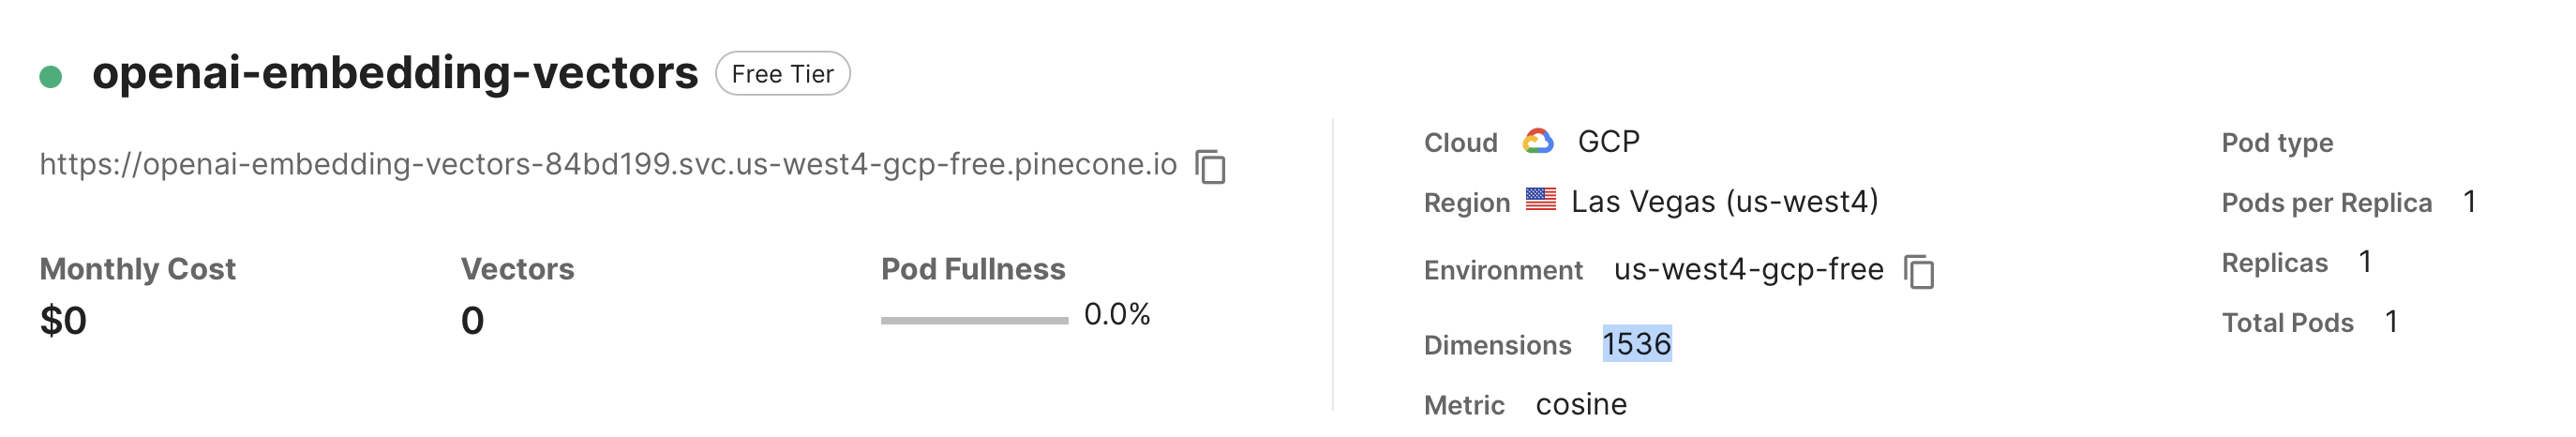

In [8]:
index_name='openai-embedding-vectors'
# check if index already exists (it shouldn't if this is first time)
if index_name not in pinecone.list_indexes():
    # if does not exist, create index
    pinecone.create_index(
        index_name,
        dimension=1536,  # dimensionality of text-embedding-ada-002
        metric='cosine',
    )
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

<font color="darkred" size="4">我们可以看到索引当前为空，total_vector_count 为 0。我们可以开始使用 OpenAI text-embedding-ada-002 构建的嵌入来填充它，如下所示：

In [9]:
for batch in dataset.iter_documents(batch_size=100):
    index.upsert(batch)

<font color="darkred" size="4">我们可以看到当前索引为空，total_vector_count 为 38950，写入了38950个langchain文本。这样我们就可以继续检索，然后生成答案。
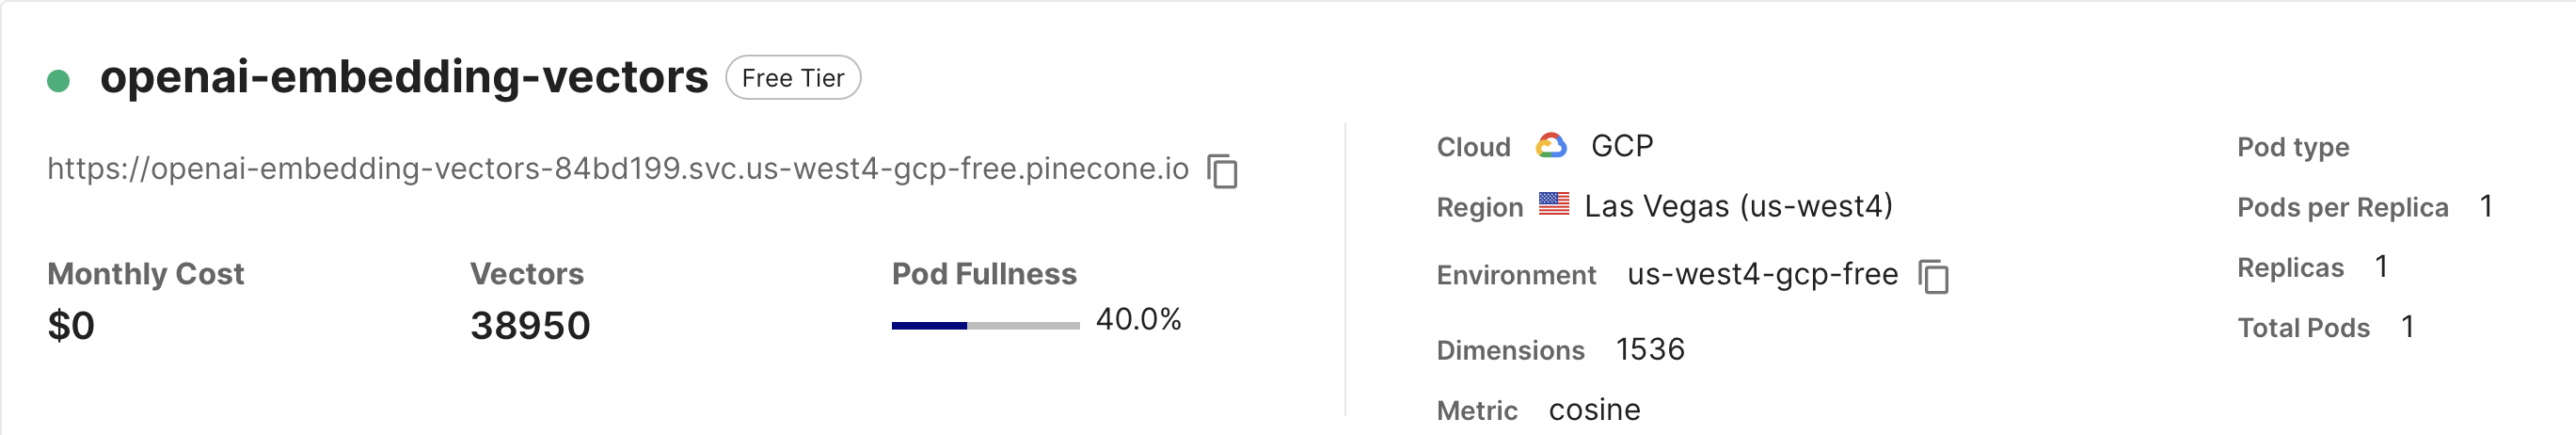

In [10]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.4,
 'namespaces': {'': {'vector_count': 38950}},
 'total_vector_count': 38950}

##<font color="blue">**搜索查询** <br>
<font color="red">要搜索文档，我们首先需要创建一个查询向量
xq。 使用 xq 我们将从 LangChain 文档中检索最相关的块。 我们将将一个查询文本传递给 OpenAI 的 Embedding API 来获取其嵌入向量，然后使用 Pinecone 向量索引进行相似向量的查询，并返回最相似的向量及其相关的元数据。这有助于在向量空间中找到与查询文本最相似的数据点。<br>



*   **要创建该查询向量，我们必须使用 OpenAI 初始化text-embedding-ada-002 嵌入模型。 为此，您需要一个 OpenAI API 密钥。**

In [11]:
import openai

# get api key from platform.openai.com
openai.api_key = 'YOUR_OPENAI_API_KEY'

embed_model = "text-embedding-ada-002"

*   **创建查询文本：首先，你创建了一个查询文本 query**
*   **获取查询文本的嵌入向量：你使用 OpenAI 的 Embedding API 将查询文本传递给 openai.Embedding.create 函数，以获取查询文本的嵌入向量。**


In [17]:
query = (
    "Which training method should I use for sentence transformers when " +
    "I only have pairs of related sentences?"
)

res = openai.Embedding.create(
    input=[query],
    engine=embed_model
)


*   **提取查询文本的嵌入向量：从 API 响应中提取查询文本的嵌入向量。具体来说，从 res 对象的数据字段中提取了嵌入向量，这个向量表示了查询文本在嵌入空间中的位置。**
*   **使用 Pinecone 进行查询：接下来，你使用之前创建的 Pinecone 向量索引 index 对查询向量 xq 进行查询。你指定了 top_k=2，表示返回相似度最高的前两个向量。此外，你还设置了 include_metadata=True，以便返回与相似向量相关的元数据。**

In [19]:
# retrieve from Pinecone
xq = res['data'][0]['embedding']

# get relevant contexts (including the questions)
res = index.query(xq, top_k=2, include_metadata=True)

In [20]:
res

{'matches': [{'id': 'pNvujJ1XyeQ-t418.88',
              'metadata': {'channel_id': 'UCv83tO5cePwHMt1952IVVHw',
                           'end': 568.0,
                           'published': datetime.datetime(2021, 11, 24, 16, 24, 24, tzinfo=tzlocal()),
                           'start': 418.0,
                           'text': 'pairs of related sentences you can go '
                                   'ahead and actually try training or '
                                   'fine-tuning using NLI with multiple '
                                   "negative ranking loss. If you don't have "
                                   'that fine. Another option is that you have '
                                   'a semantic textual similarity data set or '
                                   'STS and what this is is you have so you '
                                   'have sentence A here, sentence B here and '
                                   'then you have a score from from 0 to 1 '
   

#<font color="red">下面是一些函数来处理检索和完成步骤：

In [21]:
limit = 3750

def retrieve(query):
    res = openai.Embedding.create(
        input=[query],
        engine=embed_model
    )

    # retrieve from Pinecone
    xq = res['data'][0]['embedding']

    # get relevant contexts
    res = index.query(xq, top_k=3, include_metadata=True)
    contexts = [
        x['metadata']['text'] for x in res['matches']
    ]

    # build our prompt with the retrieved contexts included
    prompt_start = (
        "Answer the question based on the context below.\n\n"+
        "Context:\n"
    )
    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )
    # append contexts until hitting limit
    for i in range(1, len(contexts)):
        if len("\n\n---\n\n".join(contexts[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts[:i-1]) +
                prompt_end
            )
            break
        elif i == len(contexts)-1:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(contexts) +
                prompt_end
            )
    return prompt


def complete(prompt):
    # query text-davinci-003
    res = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        temperature=0,
        max_tokens=400,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res['choices'][0]['text'].strip()

<font color="green"> **首先我们从 Pinecone 中检索相关项目**

In [22]:
query_with_contexts = retrieve(query)
query_with_contexts

"Answer the question based on the context below.\n\nContext:\npairs of related sentences you can go ahead and actually try training or fine-tuning using NLI with multiple negative ranking loss. If you don't have that fine. Another option is that you have a semantic textual similarity data set or STS and what this is is you have so you have sentence A here, sentence B here and then you have a score from from 0 to 1 that tells you the similarity between those two scores and you would train this using something like cosine similarity loss. Now if that's not an option and your focus or use case is on building a sentence transformer for another language where there is no current sentence transformer you can use multilingual parallel data. So what I mean by that is so parallel data just means translation pairs so if you have for example a English sentence and then you have another language here so it can it can be anything I'm just going to put XX and that XX is your target language you can 

<font color="green"> **然后我们完成上下文注入的查询**

In [23]:
complete(query_with_contexts)

'NLI with multiple negative ranking loss.'